### Recursive multi-step forecasting with exogenous variables - August

In [10]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from sklearn.linear_model import Ridge, Lasso

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [11]:
def forecast_state_search(state, period, steps, search, regressor, lags):
    '''
    Read the data and forecast for chosen search term with chosen regressor
    Input:
    state - lowercase name of the state 
    period - last date for the data, string, format Y-m-d, maxinmum 2023-01-01
    steps - int, test split (number of weeks for test data and predicting)
    regressor - name of regressor for forecasting model 
    lags - int, on what time perion to forecast
    
    Output:
    State and Search term
    Forecaster output
    First 3 predictions
    Predictions vs actual plot
    MSE 
    Feature importances
    
    Return:
    Forecaster
    '''
    # Print state and search
    print(f'Forecast for {state} and {search} untill {period} \n' )
    
    # Read the data for the state
    df = pd.read_csv(f'../mental_health_searches/data/{state}.csv')
    df['week'] = pd.to_datetime(df['week'], format = '%Y-%m-%d')
    df = df[df['week'] < period]
    df.set_index('week', inplace=True)
    
    # Change to frequency
    df = df.asfreq('W')
    
    # Split the data to train-test
    steps = steps
    data_train = df.iloc[:-steps, :]
    data_test  = df.iloc[-steps:, :]
    
    # Create and fit forecaster
    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = lags
                )
    forecaster.fit(
        y    = data_train[search],
        exog = data_train[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
    )

    #print(forecaster)
    
    # predict
    predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['stay_at_home', 'mask_mandate', 'gatherings_banned', 'business_closures', 'travel_restrictions']]
               )
    
    # Add datetime index to predictions
    predictions = pd.Series(data=predictions, index=data_test.index)
    print('First three predictions')
    print(predictions.head(3))
    print('\n')
    
    # Plot predictions vs actual
    fig, ax=plt.subplots(figsize=(9, 4))
    data_train[search].plot(ax=ax, label='train')
    data_test[search].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()
    ax.set_title(f'Forecast for {state} and {search}', size = 20)
    ax.set_ylabel(f'{search}', size = 20)
    ax.set_xlabel('Week', size = 20);
    plt.plot()
    
    # Calculate MSE
    error_mse = mean_squared_error(
                y_true = data_test[search],
                y_pred = predictions
            )
    print(f"Test error (mse): {error_mse} \n")
    
    # Feature importances
    if ('GradientBoostingRegressor' in str(regressor)) | ('RandomForestRegressor' in str(regressor)):
        print('The importance of predictors is based on impurity.')
        print(forecaster.get_feature_importance())
    else:
        print('The coefficients of the model reflect their importance')
        print(forecaster.get_feature_importance())
        
    return forecaster

Forecast for alaska and depression untill 2020-04-01 

First three predictions
week
2019-12-22    34.180441
2019-12-29    39.565677
2020-01-05    31.125578
Freq: W-SUN, Name: pred, dtype: float64


Test error (mse): 236.51442263937514 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1    0.032632
1                 lag_2   -0.013859
2                 lag_3    0.182388
3                 lag_4    0.016488
4                 lag_5    0.114064
5                 lag_6    0.029190
6                 lag_7   -0.072546
7                 lag_8    0.009453
8                 lag_9    0.108019
9                lag_10    0.109986
10               lag_11   -0.047744
11               lag_12   -0.025569
12               lag_13    0.035979
13               lag_14    0.002360
14               lag_15   -0.029082
15         stay_at_home    0.000000
16         mask_mandate    0.000000
17    gatherings_banned    0.000000
18    business_closures 

/var/folders/qy/rrz830jj1lg9j084hkb993w40000gn/T/ipykernel_41880/1820889486.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax=plt.subplots(figsize=(9, 4))


Test error (mse): 159.57152416181106 

The coefficients of the model reflect their importance
                feature  importance
0                 lag_1    0.052799
1                 lag_2   -0.078163
2                 lag_3    0.181270
3                 lag_4    0.156241
4                 lag_5    0.118928
5                 lag_6    0.002484
6                 lag_7   -0.120384
7                 lag_8   -0.052525
8                 lag_9   -0.094320
9                lag_10    0.060675
10               lag_11    0.134320
11               lag_12    0.062241
12               lag_13   -0.048162
13               lag_14   -0.024313
14               lag_15   -0.030385
15         stay_at_home    0.000000
16         mask_mandate    0.000000
17    gatherings_banned    0.000000
18    business_closures    0.000000
19  travel_restrictions    0.000000
Forecast for hawaii and anxiety untill 2020-04-01 

First three predictions
week
2019-12-22    57.930880
2019-12-29    58.329849
2020-01-05    49.0720

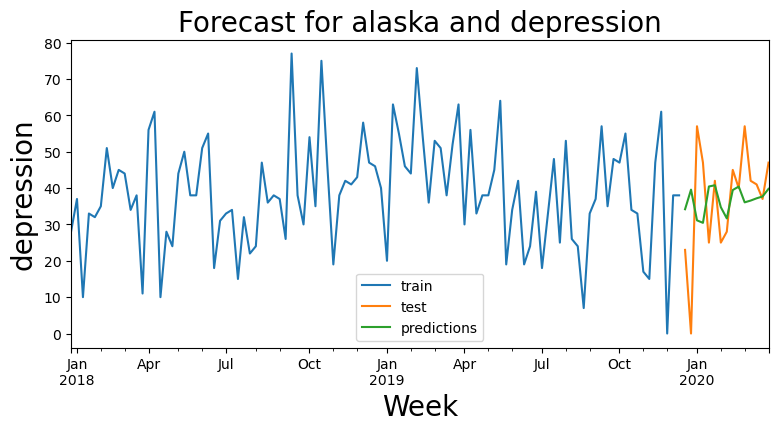

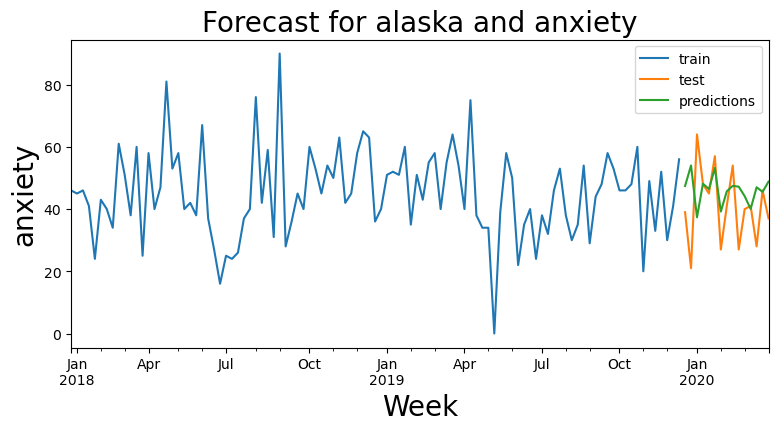

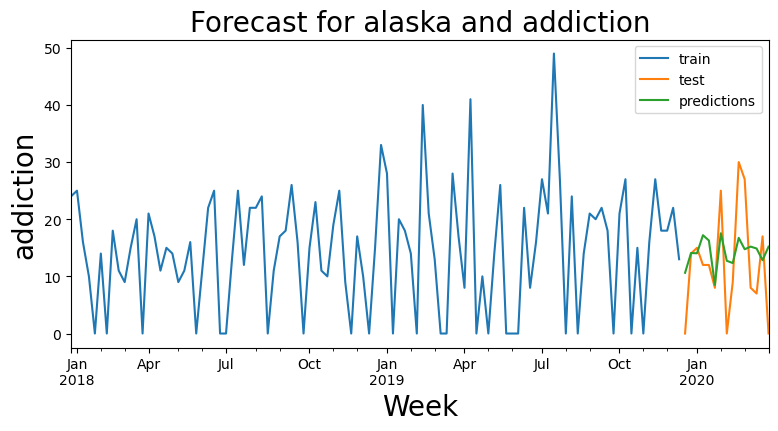

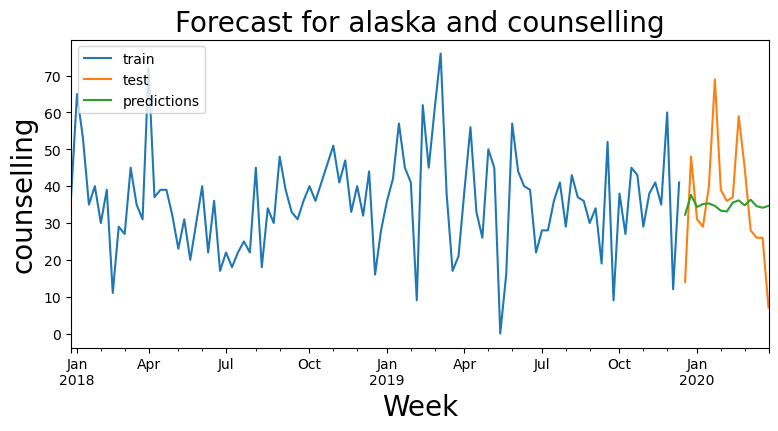

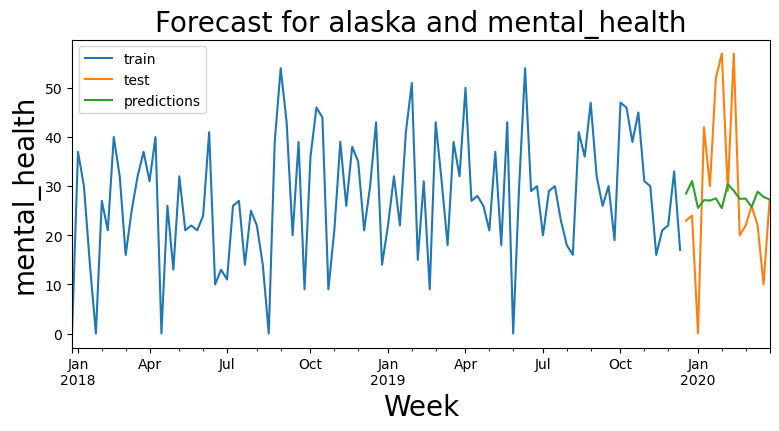

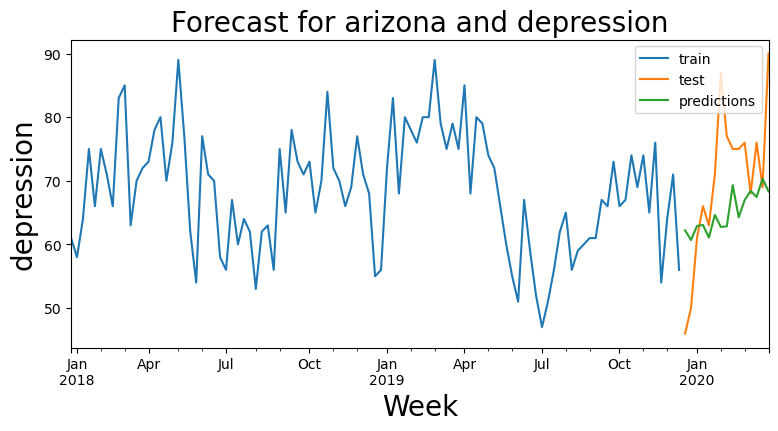

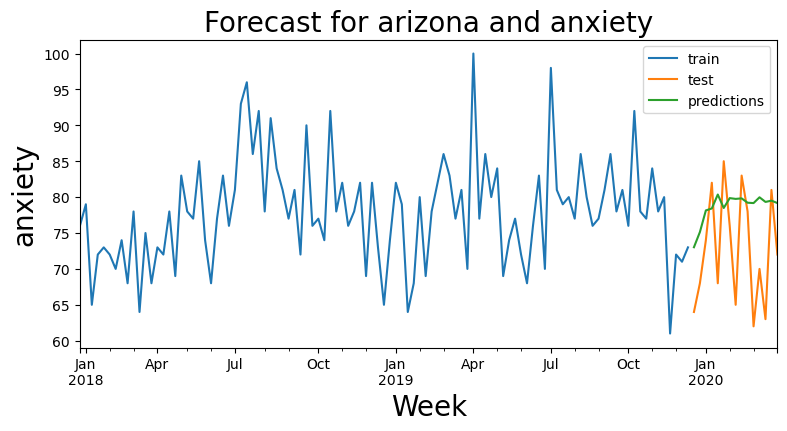

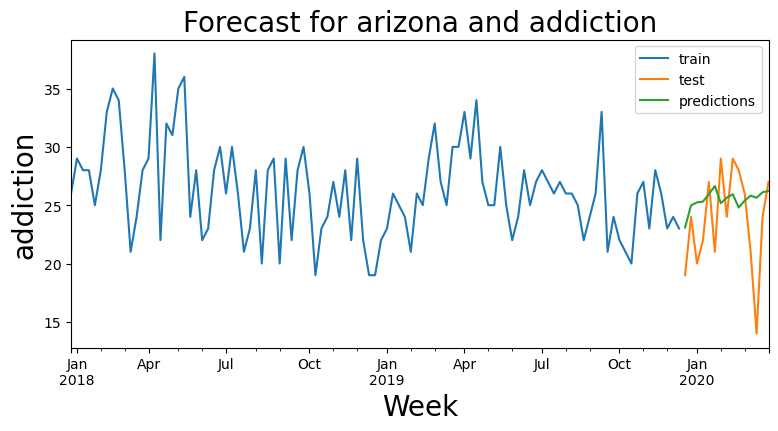

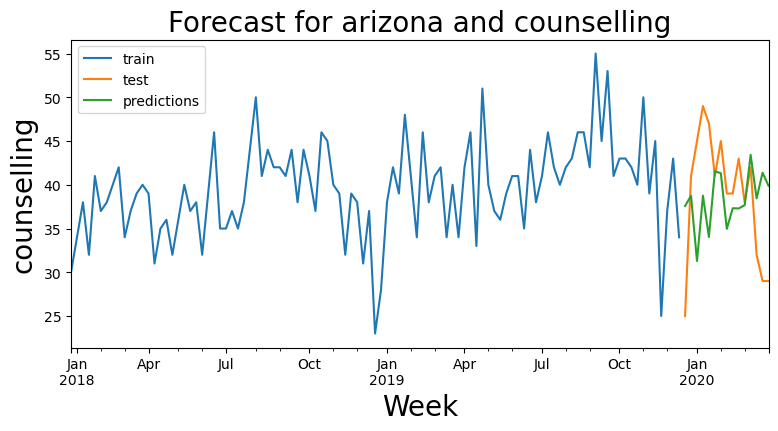

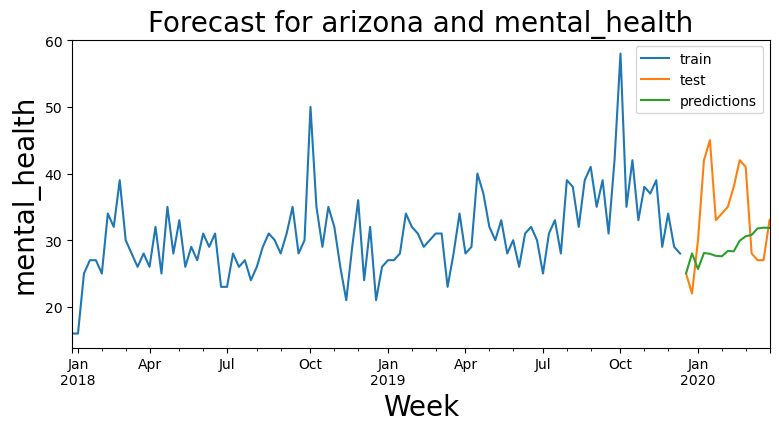

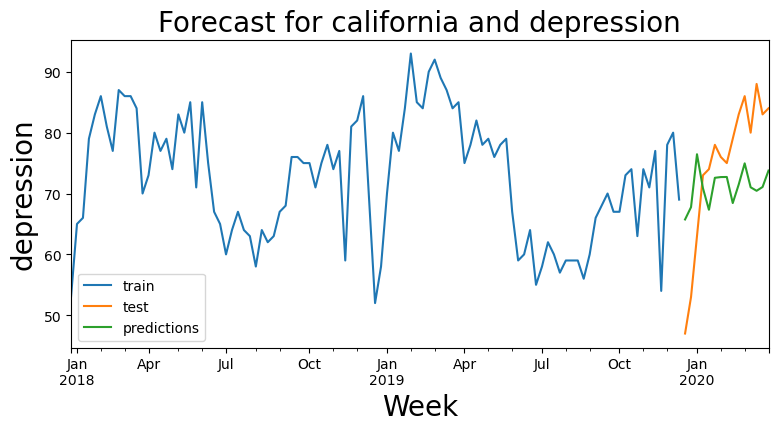

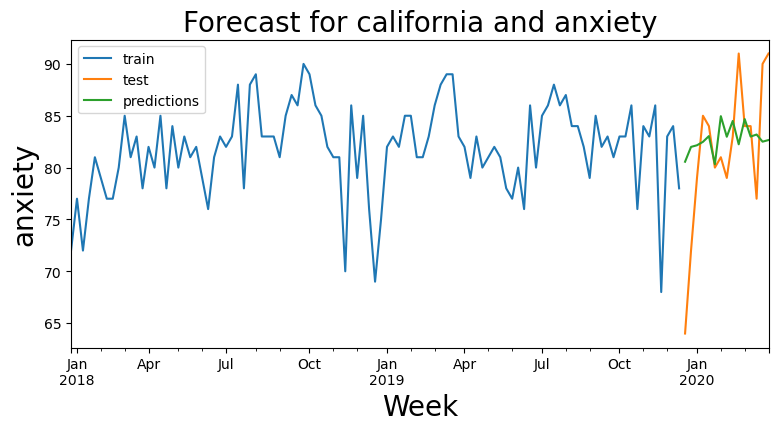

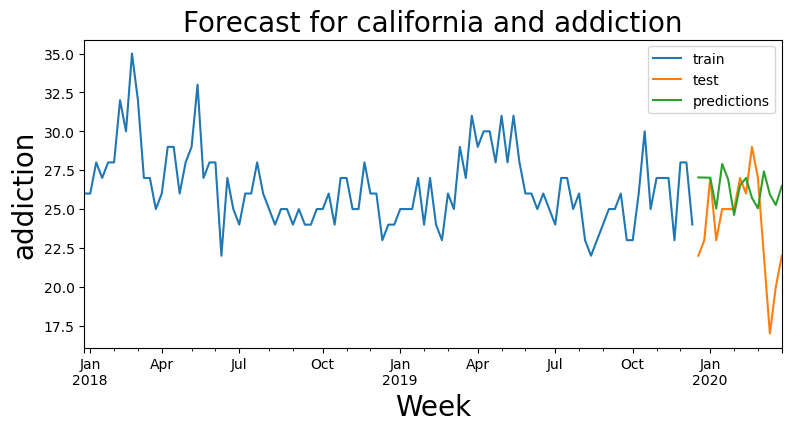

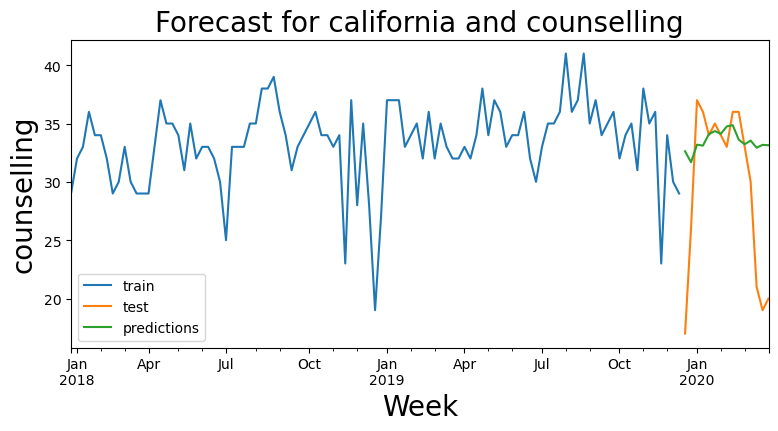

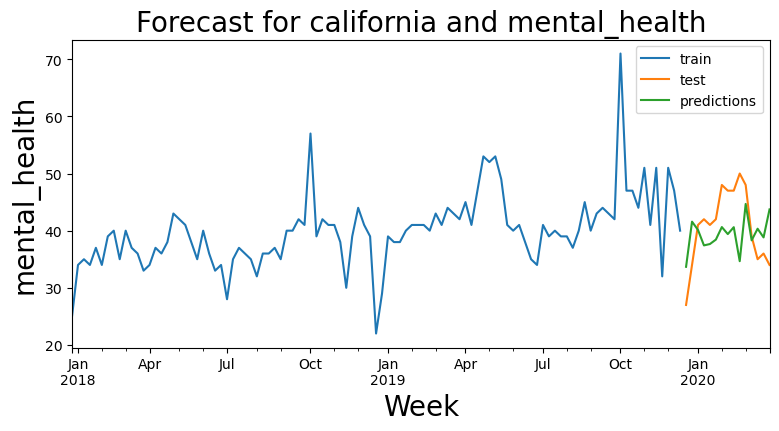

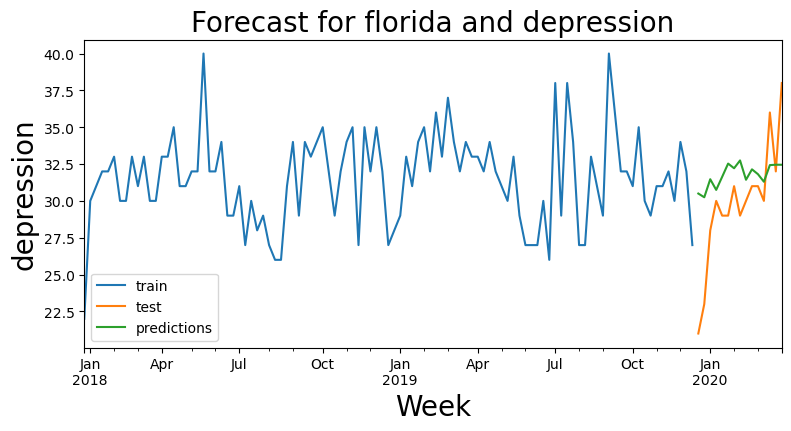

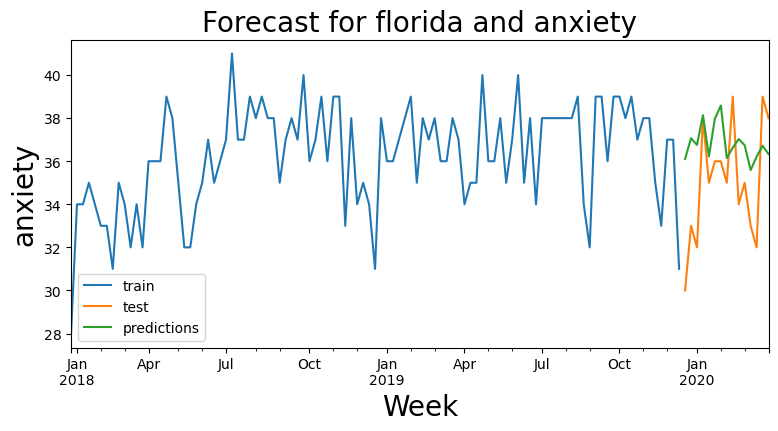

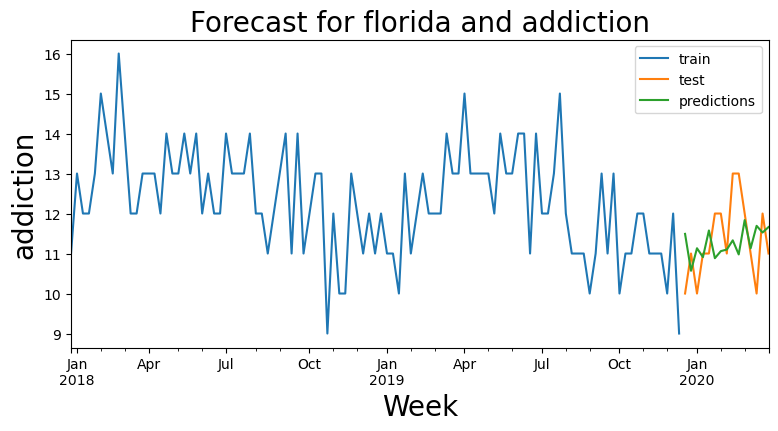

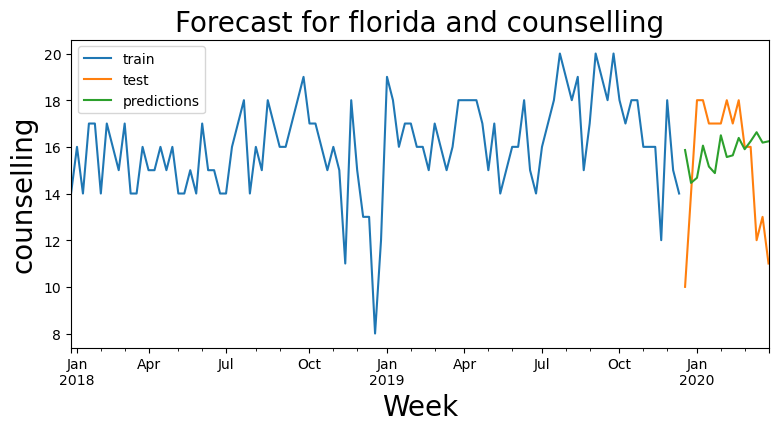

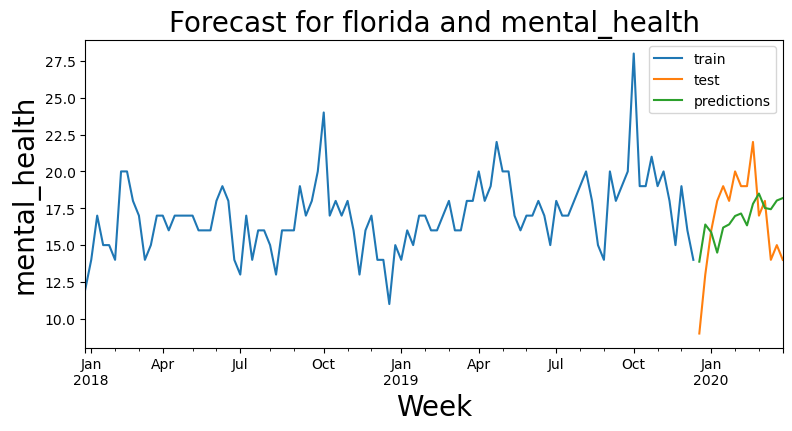

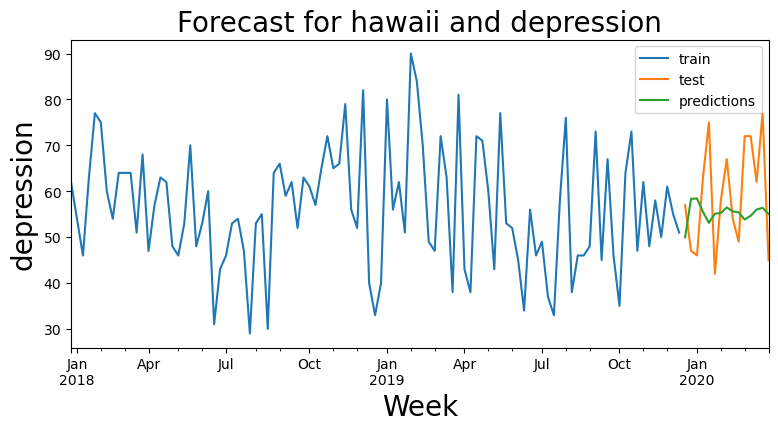

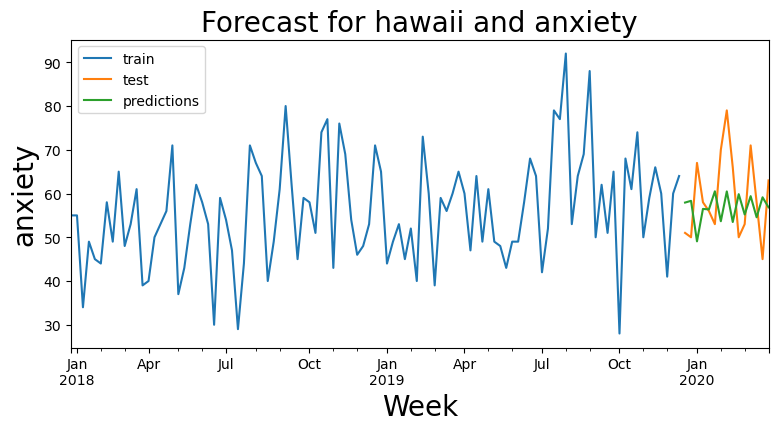

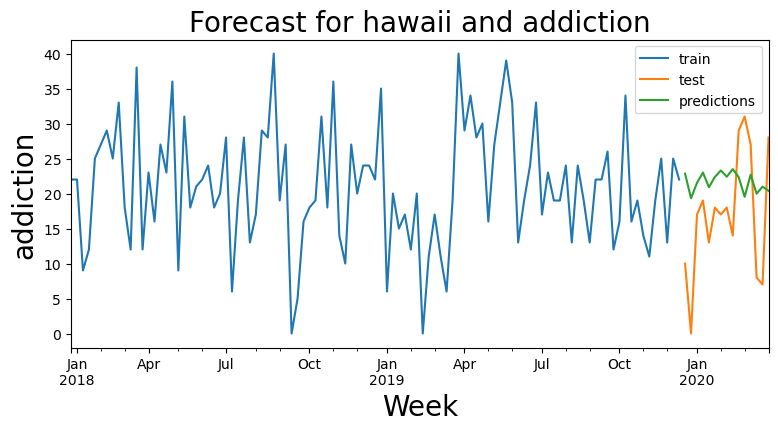

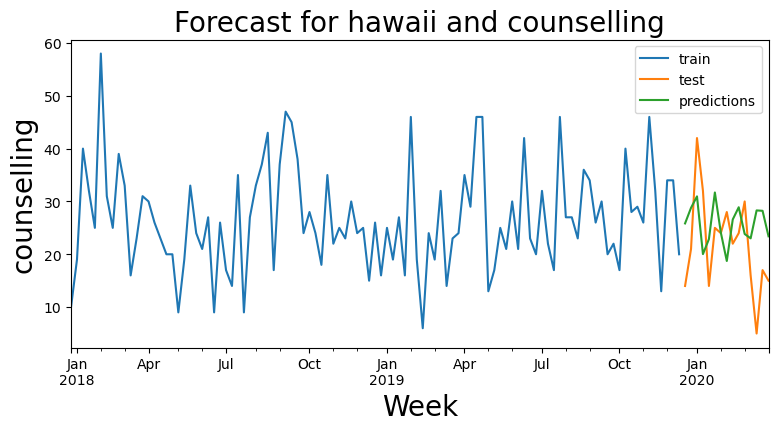

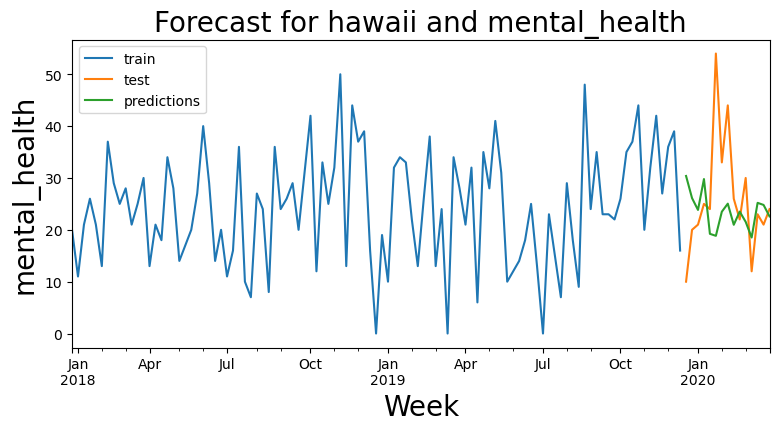

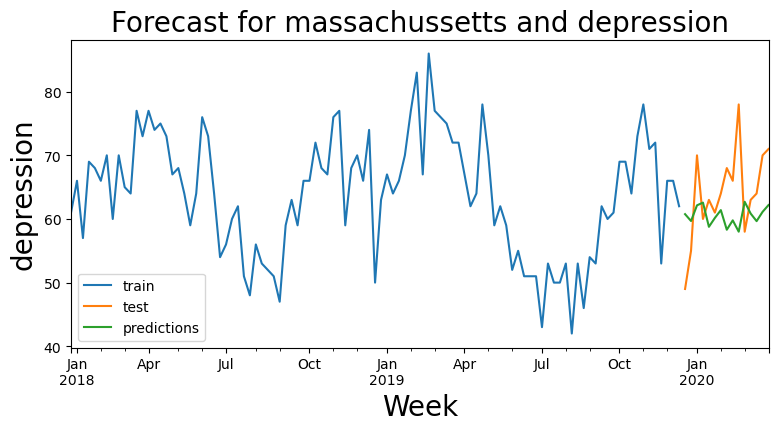

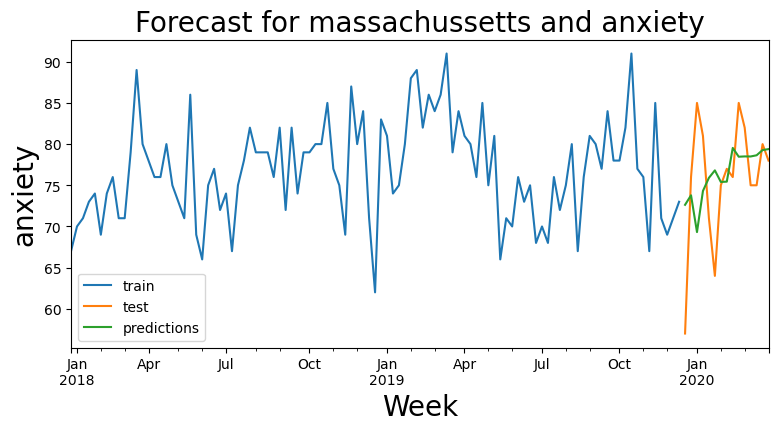

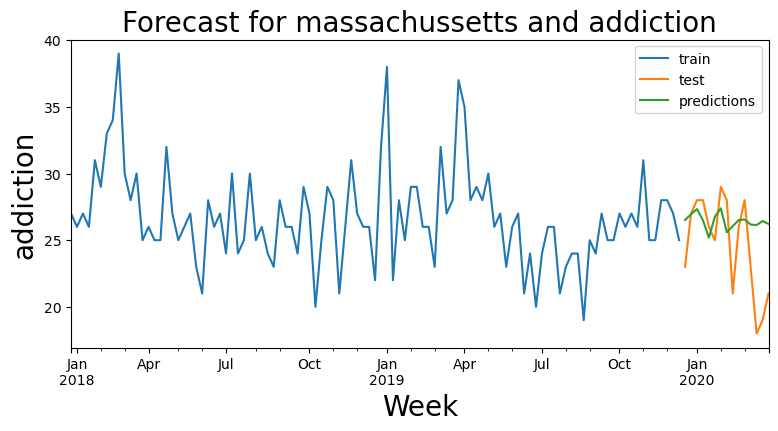

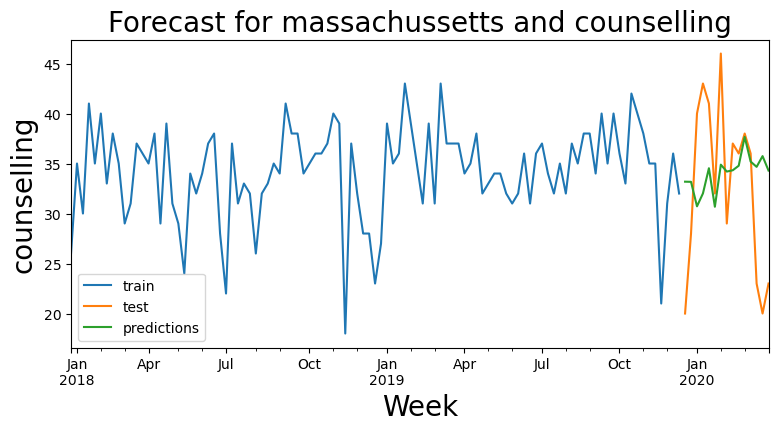

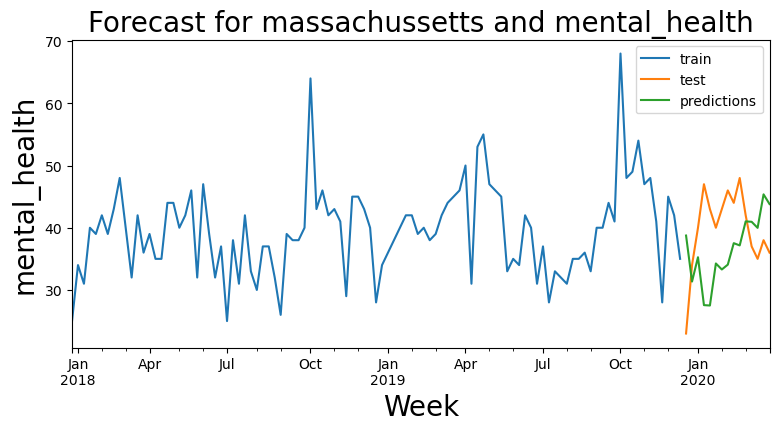

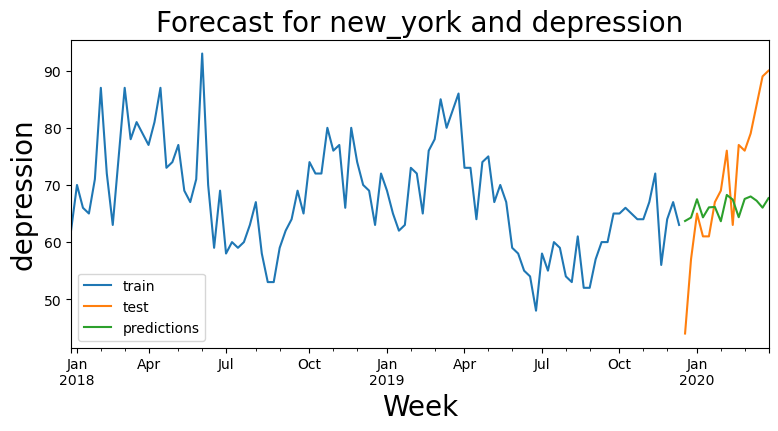

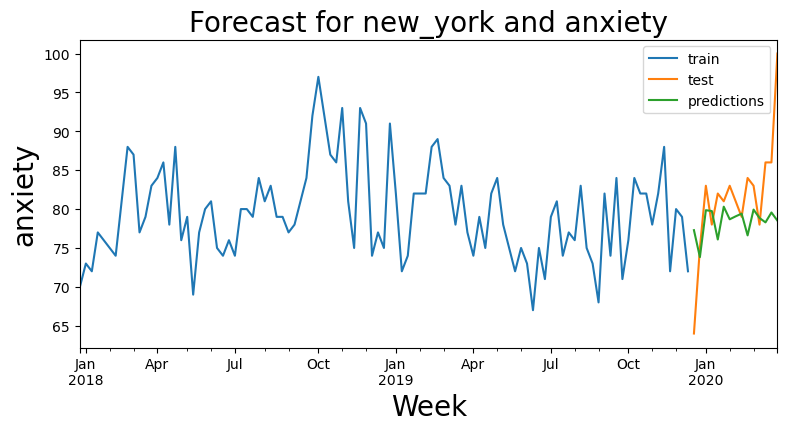

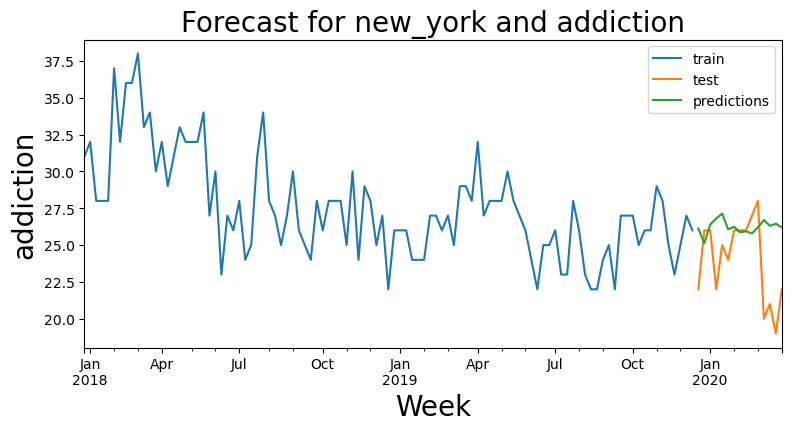

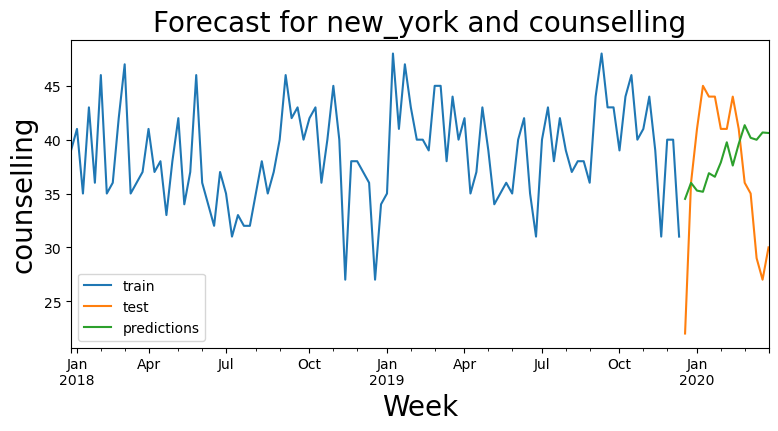

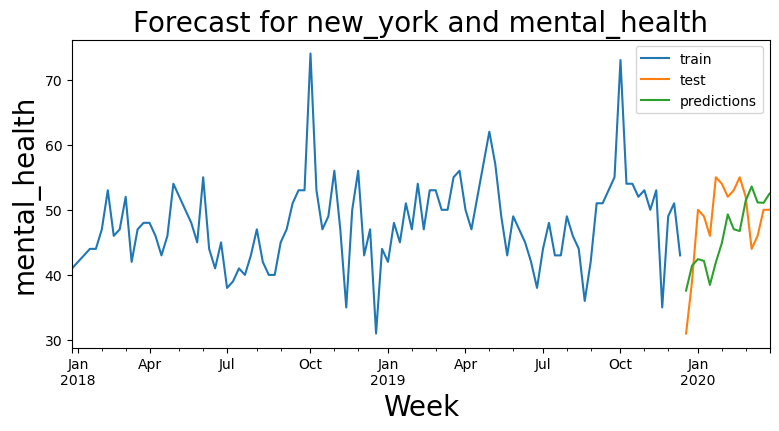

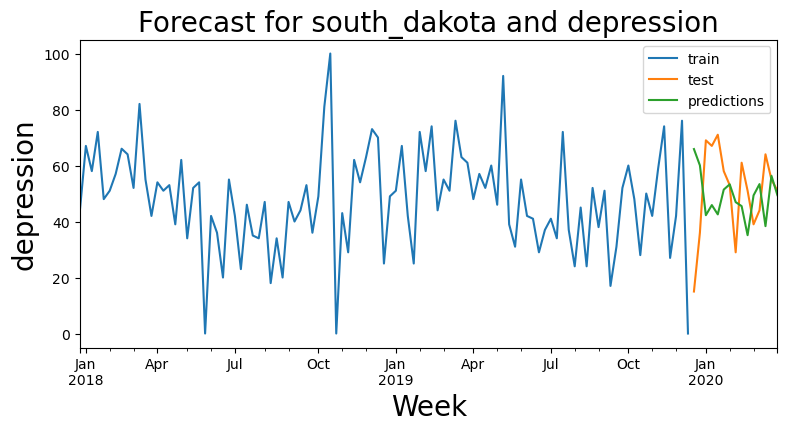

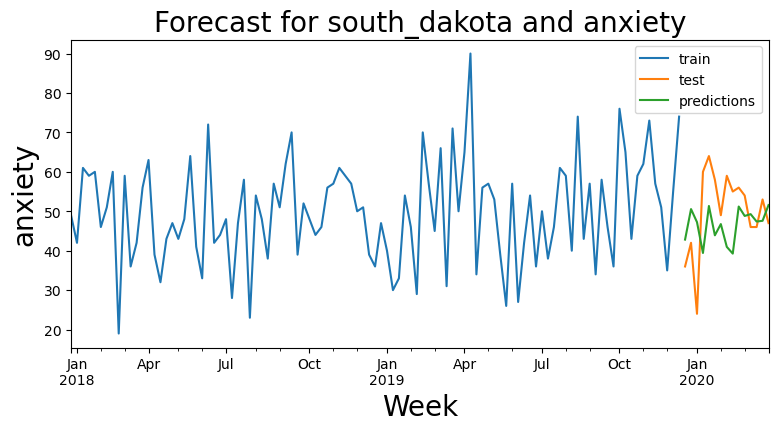

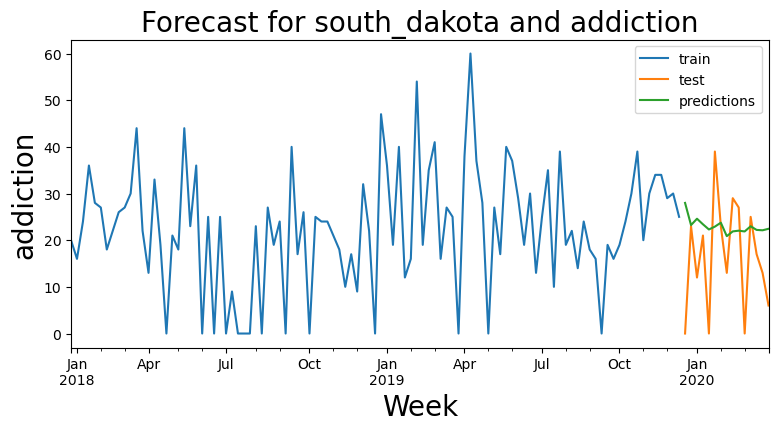

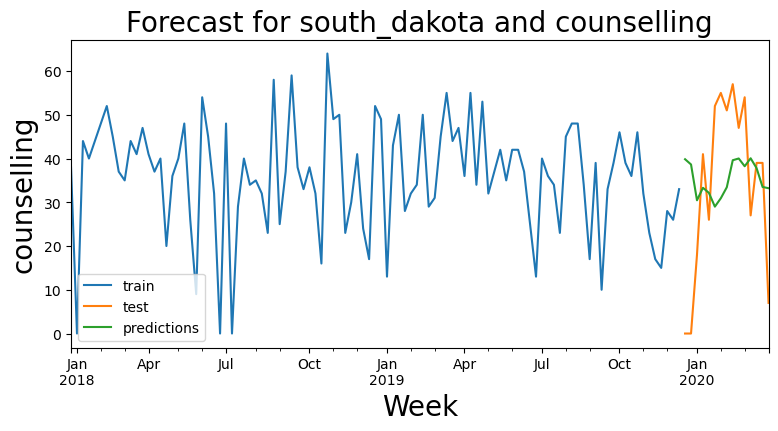

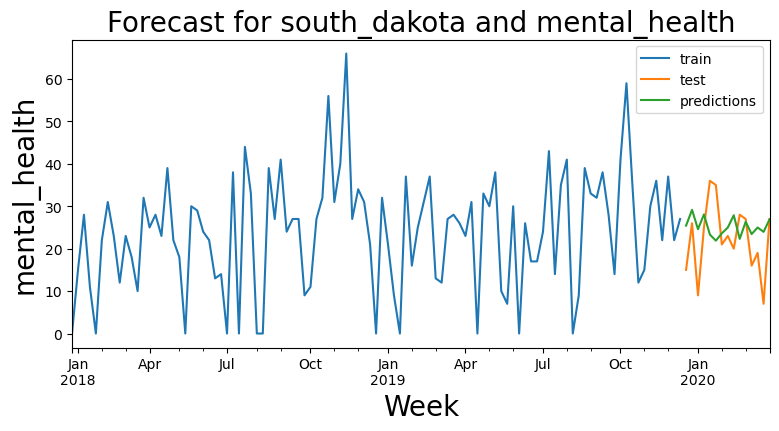

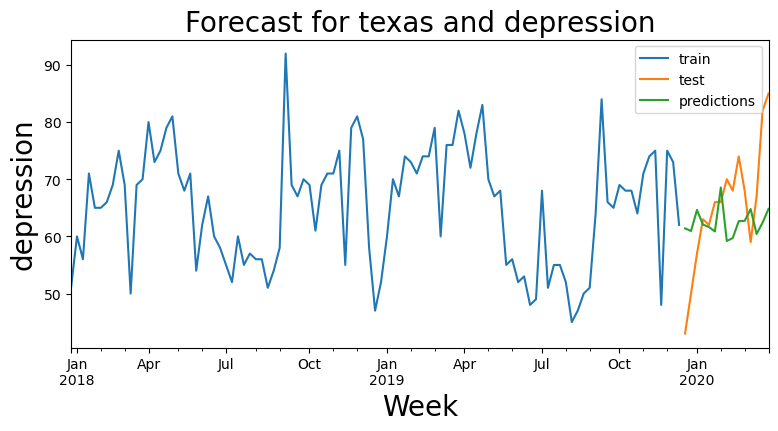

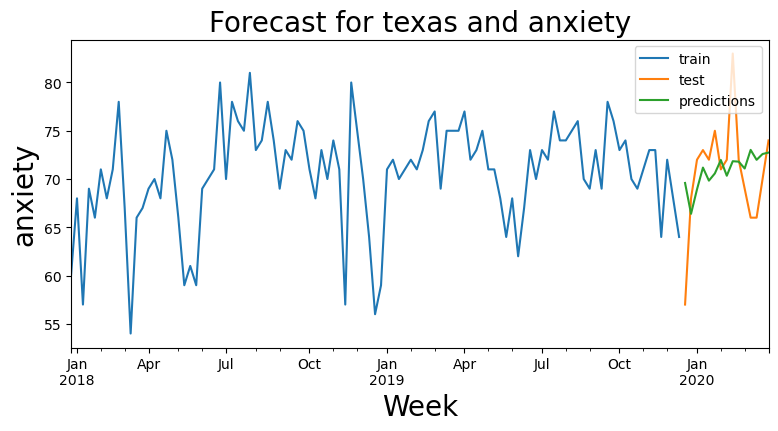

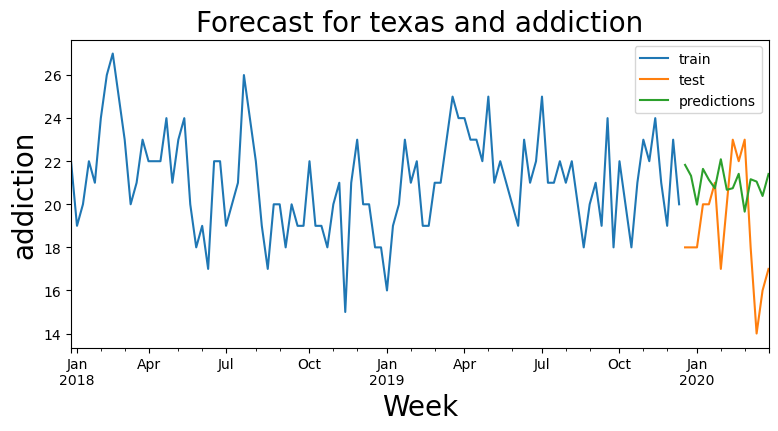

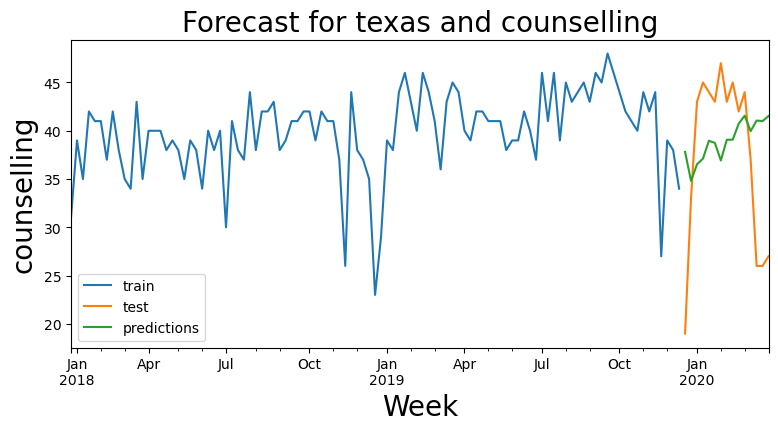

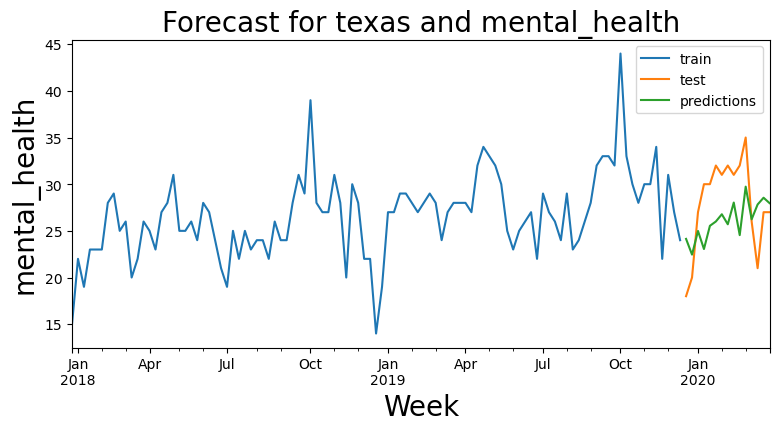

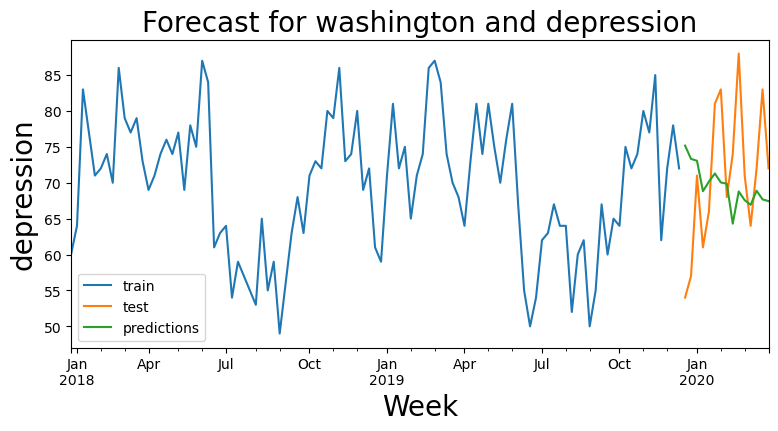

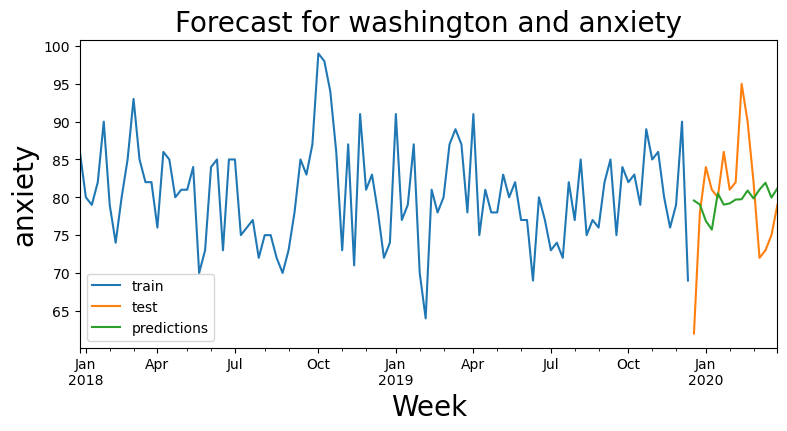

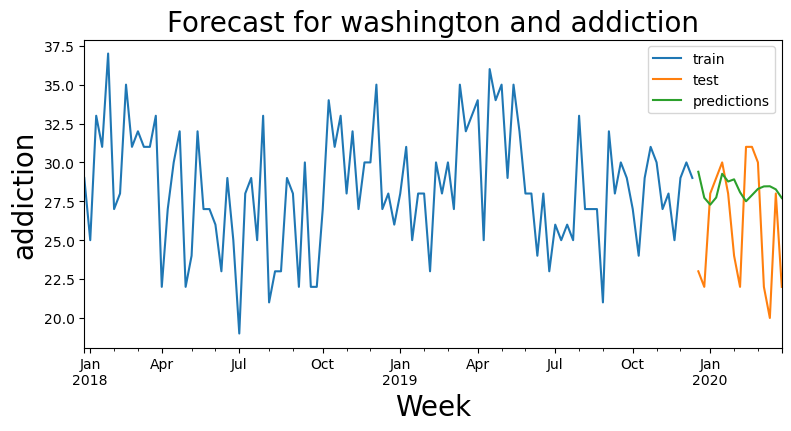

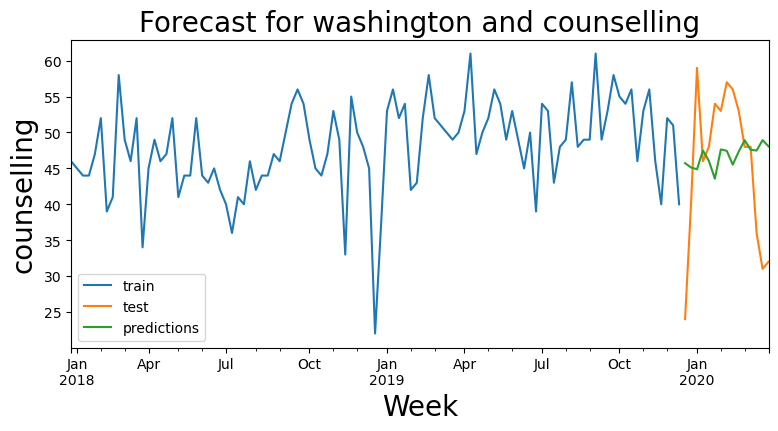

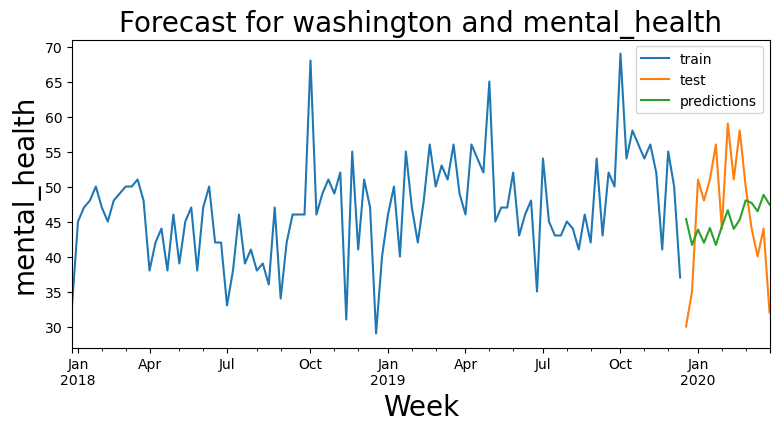

In [9]:
searches_list = ['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']
states_list = ['alaska', 'arizona', 'california', 'florida', 'hawaii', 'massachussetts', 'new_york', 'south_dakota', 'texas', 'washington']

for state in states_list:
    for search in searches_list:
        forecast_state_search(state=state, period='2020-08-01', steps=15, search=search, regressor=Ridge(), lags=15)